## **MultiModal AI Assistant !!**

In [1]:
import os 
import requests 
from bs4 import BeautifulSoup
from typing import List
from dotenv import load_dotenv
from openai import OpenAI
from ollama import Client
from groq import Groq
import gradio as gr
import json


load_dotenv(override=True)


openai = OpenAI()
MODEL_GPT = 'gpt-4.1-nano'

client = Client()
MODEL_LLAMA = 'llama3.1:8b'

d:\LLM_Engineering\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
python-dotenv could not parse statement starting at line 11


In [2]:
system_message = "You are a helpful assistant for an Airline called FlightAI."
system_message += "Give shoert, courteous answers, no more than one sentence."
system_message += "Always be accurate. If you dont know the answer, say so."

In [3]:
def chat(message, history):
    messages = [{'role': 'system', 'content': system_message}]
    for user_message, assistant_message in history:
        messages.append({'role': 'user', 'content': user_message})
        messages.append({'role': 'assistant', 'content': assistant_message})
    messages.append({'role': 'user', 'content': message})

    response = openai.chat.completions.create(model=MODEL_GPT, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat).launch()

d:\LLM_Engineering\.venv\Lib\site-packages\gradio\chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


### **Tools**  
+ Tools are incredibly powerful feature provided by the frontier LLMs.
+ With tools, you can write a function, and have the LLM call that function as part of its response.
+ Sounds almost spooky.., we are giving it power to run code on our machine ??
+ Well, kinda...

In [4]:
# Let's start by making a useful function

ticket_prices = {'london': '$799', 'paris': '$899', 'tokyo': '$1400', 'berlin': '$499'}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, 'unknown')

In [5]:
# the function

price_function = {
    "name": "get_ticket_price", 
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'how much does it take to this city?'", 
    "parameters": {
        "type": "object", 
        "properties": {
            "destination_city": {
                "type": "string", 
                "description": "The city that the customer wants to travel to.", 
            }, 
        }, 
        "required": ["destination_city"], 
        "additionalProperties": False
    }
}

In [6]:
# and this is included in a list of tools

tools = [{'type': 'function', 'function': price_function}]

In [7]:
def chat(message, history):
    messages = [{'role': 'system', 'content': system_message}]
    for user, assistant in history:
        messages.append({'role': 'user', 'content': user})
        messages.append({'role': 'assistant', 'content': assistant})
    messages.append({'role': 'user', 'content': message})

    response = openai.chat.completions.create(model=MODEL_GPT, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL_GPT, messages=messages)

    return response.choices[0].message.content

In [8]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        'role': 'tool', 
        'content': json.dumps({'destination_city': city, 'price': price}), 
        'tool_call_id': message.tool_calls[0].id
    }
    return response, city

In [10]:
gr.ChatInterface(fn=chat).launch()

d:\LLM_Engineering\.venv\Lib\site-packages\gradio\chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Berlin


### **Let's go Multi-Modal !!**
+ We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images
+ Let's put this in a function called `artist`  


> **PRICE ALERT !!** : each time I generate an image, it costs about 4c - don't go crazy with images.

In [9]:
# some imports handling images

import base64
from io import BytesIO
from PIL import Image

In [10]:
def artist(city):
    image_response = openai.images.generate(
        model='dall-e-3', 
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everthing unique about {city}, in a vibrant pop-art style.", 
        size="1024x1024", 
        n=1,
        response_format="b64_json",
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

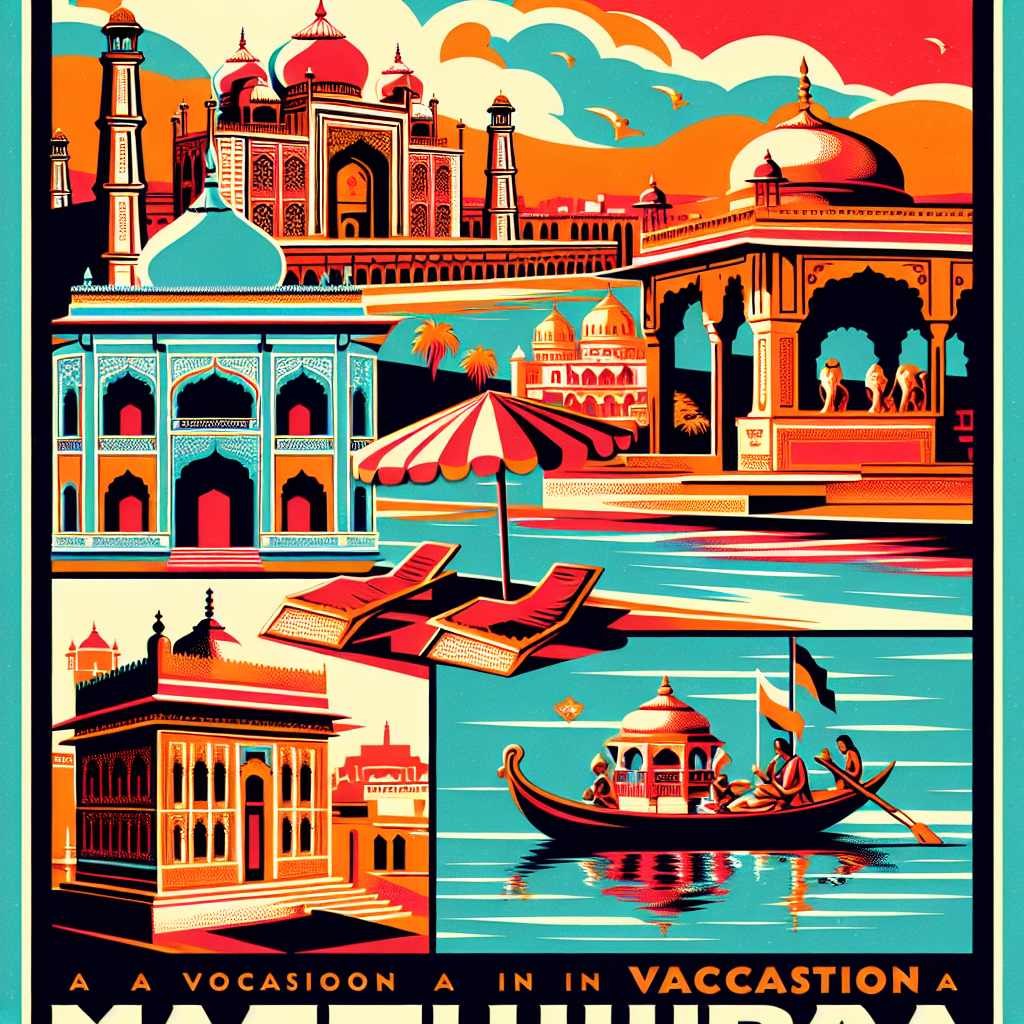

In [11]:
image = artist("Mathura")
display(image)

### **Audio**  
As let's make a function `talker` that uses OpenAI's speech model to generate audio.

In [12]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="sage",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Give papa a cup of proper coffee in a copper coffee cup.")

### **Our Agent Framework**  
The term 'Agentic AI' and Agentization is an Umbrella term that refers to a number of techniques, such as
1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialised tasks.
2. The ability for LLMs to use Tools to give them addtional capabilities. 
3. The 'Agent Environment' which allows Agents to collaborate. 
4. An LLM can act as the Planner, dividing the bigger tasks into smaller ones for the specialists.
5. The concept of an Agent having autonomy/agency, beyond just reponding to a prompt - such as Memory  

We're showing 1. and 2. here, and to a lesser extent, 3. and 5.

In [20]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL_GPT, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL_GPT, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [ ]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Berlin
